#Conectar con la API de Spotify

In [1]:
import requests 
import json
import networkx as nx
import matplotlib.pyplot as plt 
import time
from tqdm import tqdm
import numpy as np
import musicbrainzngs as mb
from os import environ
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from typing import List, Dict

In [6]:
CLIENT_ID = '14c49fbcea5a4439bfa94aa591089353'
CLIENT_SECRET = '710e61b1ca974449a6c7a23c50146cca'
# POST donde le pasamos las clave de la app
response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
# Guardamos el bearer token para usarlo en las peticiones de la API
access_token = response.json()['access_token']
headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

# OAuth_Client_ID = 'SObZ1oUfqqaJS5TLsZ2Ohy4LdqMa3Mpr'
# OAuth_Client_Secret = 'kUXJwU5WqBa5C7CkjCUITfdL6NQMd-4m'
#Identificación

mb.set_useragent('redes_complejas', 0.1) 

In [20]:
CLIENT_ID = '3a283f4bd64241238d019491e4aedca3'
CLIENT_SECRET = 'aee8c6c05d0a42c487c0069b7bd075a8'

response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
access_token = response.json()['access_token']
headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

# OAuth_Client_ID = 'SObZ1oUfqqaJS5TLsZ2Ohy4LdqMa3Mpr'
# OAuth_Client_Secret = 'kUXJwU5WqBa5C7CkjCUITfdL6NQMd-4m'
#Identificación
mb.set_useragent('redes_complejas', 0.1) 

In [4]:
mb.set_useragent('redes_complejas', 0.1) 

# Red de Colaboración de artistas

Idea: agarro un artista random, itero sobre sus canciones, y por cada canción me guardo el nombre de los artistas con los que colaboro. Por cada artista con el que colaboro repito proceso. 

Para encontrar el id de un artista tienen que abrir spotfiy y buscar al artista en cuestion y copiar todos los numeros raros que aparecen al final del link
Osea lo que va despues de : 'https://open.spotify.com/artist/..'

ahora que me guarde todas las canciones, por cada una miro si colaboro con alguien

Creo la red

#Lo hago para varios artistas a manopla, abajo lo automatizo

A veces no reconoce "items" y "artists" pero ni idea porq,. lo corro de nuevo y funca. Probando creo que es porque la api acepta una cierta cantidad de request en un tiempo.

Se me ocurrieron varias cosas del tp.

Para generar la red lo que podríamos hacer es por ejemplo, empezar con un artista cualquiera, chequear sus vecinos y a ellos hacerles todo el proceso de analizar los álbumes y generar los enlaces, así hasta que termine la red o hasta que queramos. Tipo una red ego. Lo que habría que chequear es si se puede pedir el ID de un artista pasándole su nombre.

Sino habría que scrapear una banda de artistas con sus ids y meterlos en un txt. Aunque eso lo terminaremos haciendo seguro.

La otra que se me ocurrió con machine learning es que en vez de estudiar a los años la evolución que quizá tenemos poca data es, pasarle una red incompleta y después pasarle nuevos nodos/enlaces y que nos diga de que género, género musical y país son los nodos nuevos, a ver si puede predecirlos.

La otra manera que se me ocurrió de hacer esto sin machíne learning pero no sé que tan viable es, sería analizar la homofilia de los distintos parámetros de la red y que dándole nuevos nodos, hagamos un código calculé los atributos que minimizan la diferencia de la homofilia original y la de la red, con algún algoritmo a lo modularidad.

#Definimos las cosas en funciones para agilizar el análisis.

In [32]:
def conseguir_id_y_genero(artista):
    """
    Recibe
        artista: Nombre del artista del cual se quiere su ID
    Devuelve:
        id: La ID del artista y el/los generos del artista
    """
    # End point para obtener los audio features. Esto se saca de la referencia de la documentación
    url = 'https://api.spotify.com/v1/search'

    # Búsqueda. Acá sí hay que pasarselo como parámetros
    params = {'q': f"{artista}", 'type': 'artist', 'limit': '2'}

    # En este caso no lleva ningún parámetro, el id de la canción va directamente en el url
    response = requests.get(url, params = params, headers = headers)

    # Vemos el json de la respuesta
    json_data = response.json()
    genero = json_data['artists']['items'][0]['genres']
    
    # Con la siguiente lista conseguimos el ID del primer resultado de la busqueda (creo)
    id = json_data["artists"]["items"][0]["id"]

    return (id,genero)

In [23]:

def conseguir_cuadrivector(artista): 
    """
    Recibe
        nombre: artista 
    Devuelve:
        lista de cuadrivectores: [(artista,artistas_colaborador1,idcancion,fecha), (devueltaigual),..., ]
    """
    
    id = conseguir_id_y_genero(artista)[0]
    canciones = []
    #pido la data de los albumes del artista
    url = f'https://api.spotify.com/v1/artists/{id}/albums'
    response = requests.get(url, params = {}, headers = headers)
    json_data = response.json()
    items = json_data['items']
    #me guardo todos sus albumes
    
    

    canciones_junto_a_id = []
    
    
    for indice_album,item in enumerate(items):
        año_album = items[indice_album]['release_date']
        nombre_album = items[indice_album]['id']
        
        url = f'https://api.spotify.com/v1/albums/{nombre_album}/tracks'
        response = requests.get(url, params = {}, headers = headers)
        data_albumes = response.json()
        
        #itero sobre todas las canciones de cada album y la guardo en la lista de canciones
        data_canciones = data_albumes['items']
        
        for index_cancion in range(len(data_canciones)):
            
            song = data_canciones[index_cancion]['id']
            
            url = f' https://api.spotify.com/v1/tracks/{song}'
            response = requests.get(url, params = {}, headers = headers)
            json_data = response.json()
            
            for index_colaborador in range(len(json_data['artists'])):
                
                colaborador = json_data['artists'][index_colaborador]['name'] 

                canciones_junto_a_id.append((artista,colaborador,song,año_album))
                if canciones_junto_a_id[-1][0] == canciones_junto_a_id[-1][1]: #   AGREGAMOS ESTO PARA quitar autoenlaces
                    canciones_junto_a_id.pop(-1)
    
    
    return canciones_junto_a_id

In [24]:
def crear_enlaces(nombre_artista,colaboraciones):
    # Crea una lista con todos los enlaces
    enlaces = [(nombre_artista,colaboracion) for colaboracion in colaboraciones]

    return enlaces

In [25]:
def conseguir_pais_y_genero(nombre_artista): #AGREGAR ACA SI QUEREMOS ALGUN OTRO ATRIBUTO
    
    dic_atributos = {}
    
    data = mb.search_artists(artist = nombre_artista, limit= 1)

    if data["artist-count"] != 0: #SI ENCUENTRA EL ARTISTA EN MUSIC BRANDZ
        if "country" in data["artist-list"][0]:
            pais = data["artist-list"][0]["country"]
            dic_atributos["pais"] = pais
            
        if "gender" in data["artist-list"][0]:
            genero = data["artist-list"][0]["gender"]
            dic_atributos["genero"] = genero
    
    return dic_atributos

In [26]:

# https://github.com/plamere/spotipy/blob/master/examples/playlist_tracks.py


# Authenticate to Spotify
def authenticate(cliend_id: str, client_secret: str) -> spotipy.client.Spotify:
    sp = spotipy.Spotify(
        client_credentials_manager=SpotifyClientCredentials(
            client_id=cliend_id,
            client_secret=client_secret
        )
    )

    return sp

autentificador = authenticate('14c49fbcea5a4439bfa94aa591089353','710e61b1ca974449a6c7a23c50146cca')
# Number of tracks available in the playlist
def get_pl_length(sp: spotipy.client.Spotify, pl_uri: str) -> int:
    return sp.playlist_tracks(
        pl_uri,
        offset=0,
        fields="total"
    )["total"]
    
    
def get_tracks_artist_info(sp: spotipy.client.Spotify, pl_uri: str) -> List[List[Dict]]:
    artists_info = list()
    # Start retrieving tracks from the beginning of the playlist
    offset = 0
    pl_length = get_pl_length(sp, pl_uri)

    # Playlist track retrieval only fetches 100 tracks at a time, hence\
    # the loop to keep retrieving until we reach the end of the playlist
    while offset != pl_length:
        # Get the next batch of tracks
        pl_tracks = sp.playlist_tracks(
            pl_uri,
            offset=offset,
            fields="items.track"
        )

        # Get the list with the info about the artists of each track from the\
        # latest batch and append it to the running list
        
        [artists_info.append(pl_item["track"]["artists"]) for pl_item in pl_tracks["items"]]

        # Update the offset
        offset += len(pl_tracks["items"])

    return artists_info



In [ ]:
artistas_argentinos = []

data_artistas = get_tracks_artist_info(autentificador,"https://open.spotify.com/playlist/6oF4i9FMoWGfvwUUI7IpgH?si=604e37fad5304c52")
for artista in data_artistas:
    nombre_artista = artista[0]["name"]
    pais_y_genero_artista = conseguir_pais_y_genero(nombre_artista)
    try:
        if pais_y_genero_artista["pais"] == "AR" and nombre_artista not in artistas_argentinos:
            artistas_argentinos.append(nombre_artista)
    except:
        print()

In [10]:
print(artistas_argentinos)
print(len(artistas_argentinos)) ##LA PLAYLIST TIENE 50 ARTISTAS, SOLO 3 NO TIENEN "COUNTRY" o no son AR.

['Charly García', 'Soda Stereo', 'Los Abuelos De La Nada', 'Los Enanitos Verdes', 'Virus', 'WOS', 'David Lebón', 'Los Piojos', 'Divididos', 'Gustavo Cerati', 'Conociendo Rusia', 'Fito Paez', 'Las Pastillas del Abuelo', 'Estelares', 'Vicentico', 'Luis Alberto Spinetta', 'Indio Solari', 'Sumo', 'Eruca Sativa', 'Emmanuel Horvilleur', 'Dante Spinetta', 'Skay Beilinson', 'Callejeros', 'Attaque 77', 'La Franela', 'Intoxicados', 'Los Caballeros De La Quema', 'Los Fabulosos Cadillacs', 'Tan Bionica', 'Bersuit Vergarabat', 'Las Pelotas', 'La Beriso', 'La Renga', 'Turf', 'Andrés Calamaro', 'Los Auténticos Decadentes', 'Gustavo Cordera', 'Serú Girán', 'Pappo', 'Dread Mar I', 'Babasónicos', 'Ivan Noble', 'Guasones']
43


In [ ]:
#URLS DE PLAYLIST CON ARTISTAS ARGENTINOS:
#rock nacional, folcrore argentino, los 90 argentina.

artistas_argentinos = []
artistas_quiza_argentinos = []

playlists = ["https://open.spotify.com/playlist/37i9dQZF1DX2v4h8QERQPb?si=f0244631d0084cb6","https://open.spotify.com/playlist/4BfzTfnImLBKkhYZwgsRMO?si=562120a745954c53","https://open.spotify.com/playlist/6GxBZn0yu0miclv2bhImBd?si=c513cd4ed3784604", "https://open.spotify.com/playlist/37i9dQZF1DX8KUmmjlkOod?si=fbfbb389e3034a54","https://open.spotify.com/playlist/6oF4i9FMoWGfvwUUI7IpgH?si=604e37fad5304c52"] 

for playlist in playlists:
    data_artistas = get_tracks_artist_info(autentificador,playlist)
    
    
    for artista in data_artistas:
        
        nombre_artista = artista[0]["name"]
        # print(nombre_artista)
        
        pais_y_genero_artista = conseguir_pais_y_genero(nombre_artista)
        
        try:
            if pais_y_genero_artista["pais"] == "AR" and nombre_artista not in artistas_argentinos:
                artistas_argentinos.append(nombre_artista)
        except:
            if nombre_artista not in artistas_quiza_argentinos:
            
                artistas_quiza_argentinos.append(nombre_artista)

La siguiente celda es para mergear la que tira last fm con la de Nico

In [13]:
import requests
from bs4 import BeautifulSoup as BS 
import time
import numpy as np
response = requests.get("https://www.last.fm/es/tag/argentina/artists")

# Vemos el contenido que nos devolvió
print(response.status_code)
soup = BS(response.content)
urls = []
for i in range(2,49):
    urls.append(f'https://www.last.fm/es/tag/argentina/artists?page={i}')
artistas = []
artistas_argentinos = []
artistas_quiza_argentinos = []
for url in urls:
    response = requests.get(url)
    soup = BS(response.content)
    elements = soup.findAll(attrs = {"class": "big-artist-list-title"})
    for element in elements:
        artistas.append(element.a.text)

for artista in artistas:  
        pais_y_genero_artista = conseguir_pais_y_genero(artista)
        time.sleep(1)
        try:
            if pais_y_genero_artista["pais"] == "AR" and artista not in artistas_argentinos:
                artistas_argentinos.append(artista)
        except:
            if artista not in artistas_quiza_argentinos:
                artistas_quiza_argentinos.append(artista)
artistas_argentinos_nico = ['Bardero$', 'WOS', 'YSY A', 'Nicki Nicole', 'Dani Ribba', 'Dillom', 'Bizarrap', 'Trueno', 'Homer El Mero Mero', 'ACRU', 'Franky Style', 'Kris Alaniz', 'Kodigo', 'Fianru', 'Lil Troca', 'Veeyam', 'Marcianos Crew', 'KHEA', 'Frijo', 'FMK', 'Lucho SSJ', 'Pekeño 77', 'Chaqueño Palavecino', 'Soledad', 'Horacio Guarany', 'Los Huayra', 'Facundo Toro', 'Los Nombradores del Alba', 'Nacho Prado Y Daniel Campos', 'Sandra Luna', 'Los Chalchaleros', 'Jorge Rojas', 'Daniel Toro', 'Los Nocheros', 'Luciano Pereyra', 'Roberto Carabajal', 'Abel Pintos', 'Peteco Carabajal', 'Roxana Carabajal', 'Mercedes Sosa', 'Raly Barrionuevo', 'Andrés Calamaro', 'Soda Stereo', 'Los Fabulosos Cadillacs', 'Los Auténticos Decadentes', 'Los Enanitos Verdes', 'Luis Alberto Spinetta', 'Gustavo Cerati', 'Fito Paez', 'Los Pericos', 'Patricio Rey y sus Redonditos de Ricota', 'Vilma Palma e Vampiros', 'Los Caballeros De La Quema', 'Attaque 77', 'Diego Torres', 'Gilda', 'Grupo Sombras', 'El Soldado', 'Fabiana Cantilo', 'Los Piojos', 'Bersuit Vergarabat', 'La Portuaria', 'Los Ladrones Sueltos', 'Memphis La Blusera', 'La Mosca Tse-Tse', 'Divididos', 'Sergio Denis', 'León Gieco', 'Charly García', 'Rafaga', 'Illya Kuryaki & The Valderramas', 'La Zimbabwe', 'Rata Blanca', 'Manuel Wirzt', 'Alcides', 'Los Abuelos De La Nada', 'Virus', 'David Lebón', 'Conociendo Rusia', 'Las Pastillas del Abuelo', 'Estelares', 'Vicentico', 'Indio Solari', 'Sumo', 'Eruca Sativa', 'Emmanuel Horvilleur', 'Dante Spinetta', 'Skay Beilinson', 'Callejeros', 'La Franela', 'Intoxicados', 'Tan Bionica', 'Las Pelotas', 'La Beriso', 'La Renga', 'Turf', 'Gustavo Cordera', 'Serú Girán', 'Pappo', 'Dread Mar I', 'Babasónicos', 'Ivan Noble', 'Guasones']
artistas_quiza_argentinos_nico = ['Duki', 'El Triangulo Estudio', 'Ronpe 99', 'G Sony', 'Slim Dee', 'Ronpe 99', 'Flaco Vazquez', 'Slim Dee', 'Brapis', 'Wolty', 'Dtoke', 'Iacho', 'Rapstinencia', 'La Joaqui', 'Urbanse', 'Urbanse', 'Wolty', 'Zica', 'Ronpe 99', 'Zica', 'Ronpe 99', 'Duki', 'Duki', 'Khea;Omar Varela', 'LIT killah', 'Duki', 'Duki', 'Duki', 'LIT killah', 'Duki', 'Neo Pistea', 'Seven Kayne', 'Duki', 'LIT killah', 'Duki', 'Duki', 'Duki', 'Midel', 'Seven Kayne', 'Ecko', 'Ecko', 'Luck Ra;Seven Kayne', 'Cumbia Trampa', 'Duki', 'Duki', 'Zanto', 'Neo Pistea', 'Felp 22', 'LIT killah', 'Seven Kayne', 'Neo Pistea', 'Duki', 'Duki', 'Duki', 'Duki', 'Duki', 'Duki', 'Antezanax 247', 'Campedrinos', 'Sergio Galleguillo', 'Tamara Castro', 'Los Rojas', 'Campedrinos', 'Campedrinos', 'Campedrinos', 'Campedrinos', 'Campedrinos', 'Daniela Toro', 'Sergio Galleguillo Y Los Amigos', 'Campedrinos', 'Los Carabajal', 'Tamara Castro', 'Campedrinos', 'Tamara Castro', 'Sergio Galleguillo', 'Sergio Galleguillo Y Los Amigos', 'Amboé', 'Campedrinos', 'Campedrinos', 'Amar Azul']

#mergeo lo de nico con lo de ari

artistas_argentinos = artistas_argentinos+artistas_argentinos_nico
artistas_quiza_argentinos = artistas_quiza_argentinos + artistas_quiza_argentinos_nico

200


In [8]:
import pickle
pickle.dump(artistas_argentinos, open('lista artistas argentinos', 'wb'))
pickle.dump(artistas_quiza_argentinos, open('lista artistas quiza argentinos', 'wb'))


In [ ]:
with open('lista artistas argentinos', 'rb') as f:
    artistas_argentinos = pickle.load(f)


In [ ]:
# Defino una lista con todos los artistas

# Defino una lista para guardar los enlaces
cuadrivectores_artistas_argentinos = []

for artista in artistas_argentinos:
    lista_cuadrivectores = conseguir_cuadrivector(artista)
    for vector in lista_cuadrivectores:
        nombre_colaborador = vector[1]
        pais_y_genero_colaborador = conseguir_pais_y_genero(nombre_colaborador)
        time.sleep(2)
        try:
            if pais_y_genero_colaborador["pais"] == "AR":
                cuadrivectores_artistas_argentinos.append(vector)
        except:
            pass

In [34]:
client_ids = ['3a283f4bd64241238d019491e4aedca3',"5b52471dd4894ebbbbd0a5b63e33cf63","3a533c6fd3434a29a09896712d5c19bd","14c49fbcea5a4439bfa94aa591089353","8b3a74b411c14db295be20c03a164241","62dad7314da84b22b885bab72e7f2d60"]
client_secrets = ['aee8c6c05d0a42c487c0069b7bd075a8',"62730cfc96a54bc298c2587228ac147e", "65f9ad113dd54f6091cee7aa5498568b","710e61b1ca974449a6c7a23c50146cca","9078850544c14866b525ab61aa7dfdf2","7a346376cdaf43948b16b436ca62c8a9"]

In [37]:
i = 0
index_aut = 0

cuadrivectores_artistas_argentinos = []

#NOS AUTENTIFICAMOS PRIMERO
response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': client_ids[0], 'client_secret': client_secrets[0]})
access_token = response.json()['access_token']
headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'} 

#RECORREMOS LA LISTA DE ARTISTAS HASTA TERMINARLA: i ES EL INDICE QUE RECORRE
while i < len(artistas_argentinos):
    
    artista = artistas_argentinos[i] #DEFINO EL ARTISTA
    
    try:
        
        lista_cuadrivectores = conseguir_cuadrivector(artista)  #CONSIGO LOS CUADRIVECTORES DEL ARTISTA
        cuadrivectores_artistas_argentinos.append(lista_cuadrivectores)
        #MUTEO LO SIGUIENTE PQ SOLO SE FIJARIA SI MUSICBRANDZ CREE Q SON ARGENTINOS.
        # for vector in lista_cuadrivectores:
        #     nombre_colaborador = vector[1]
        #     pais_y_genero_colaborador = conseguir_pais_y_genero(nombre_colaborador)
        #     time.sleep(1)
        #     if pais_y_genero_colaborador["pais"] == "AR":
        #         cuadrivectores_artistas_argentinos.append(vector)
        
        i += 1 #PASAMOS AL SIGUIENTE ARTISTA
                
    except Exception as e: 
        
        print(e)
        print(artista)
        index_aut += 1
        if index_aut == len(client_ids):
            index_aut = 0
        response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': client_ids[index_aut], 'client_secret': client_secrets[index_aut]})
        access_token = response.json()['access_token']
        headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'} 
            

In [38]:
print(cuadrivectores_artistas_argentinos)

[[('WOS', 'Ricardo Mollo', '0BTJ7QpDRjinzAy8KQMAp8', '2021-11-18'), ('WOS', 'CA7RIEL', '0Wz6TToEPwxzH482fuGEwO', '2021-11-18'), ('WOS', 'Nicki Nicole', '2y2iEADc8O0Vv5IKHSs21i', '2021-11-18'), ('WOS', 'Vetusta Morla', '4yR8Rv6UBRvJaFz2Hd8iik', '2022-09-15'), ('WOS', 'LOUTA', '0bhWW1Bve1Ng6kEm8WjiQA', '2022-06-16'), ('WOS', 'MANU OLIVA', '1dKjLvlAPTPlhRCFyA84Z9', '2020-05-21'), ('WOS', 'La Bomba de Tiempo', '2MuDW3QK1SAk35OnTnDLLp', '2019-10-25'), ('WOS', 'Baltasar Comotto', '2MuDW3QK1SAk35OnTnDLLp', '2019-10-25'), ('WOS', 'ACRU', '06b0Au6pvZiO03eKTCvgWh', '2019-07-19'), ('WOS', 'Banzai FC', '1IJcROM3wuO4phCdjlEl5t', '2017-12-29')], [('Soda Stereo', 'Adrián Taverna', '4w6H3Lp3OXZzuaX0ErmDFj', '1991-10-09'), ('Soda Stereo', 'Adrián Taverna', '0p7QgMQFWJtOolnT931643', '1991-10-09'), ('Soda Stereo', 'Adrián Taverna', '1DpNSeT4qyLbTaO57yy7Zy', '1991-10-09'), ('Soda Stereo', 'Adrián Taverna', '5eQyg5gj0K5FXNL9Ij615e', '1991-10-09'), ('Soda Stereo', 'Adrián Taverna', '70d8LfiFSIMeRxDtz7nHIk',

In [14]:
cuadrivectores_artistas_argentinos1 = [('Kevin Johansen', 'León Gieco', '5gDKOsPsqPIyr4mMo1vAt5', '2015-03-31'), ('Kevin Johansen', 'León Gieco', '4BoFcP8A2ihsCtnYIg3nvI', '2003-11-18'), ('Kevin Johansen', 'León Gieco', '5A3oOLjrYvOerhRo7ZdYUc', '2003-11-04'), ('Kevin Johansen', 'Sol Pereyra', '3OdY3pQ1pD9PKcuOCKZEJD', '2022-09-29'), ('Kevin Johansen', 'Sol Pereyra', '6qraLvAhH8yqerdbG5yAQc', '2022-09-29'), ('Attaque 77', 'Vitillo Ábalos', '4Qegee14M1eKynWh1ZIvuV', '2019-03-25'), ('Attaque 77', 'Peteco Carabajal', '4Qegee14M1eKynWh1ZIvuV', '2019-03-25'), ('Attaque 77', 'Vitillo Ábalos', '7hLQ6QhSHGF4rasbbmlnmn', '2016-11-18'), ('Attaque 77', 'Peteco Carabajal', '7hLQ6QhSHGF4rasbbmlnmn', '2016-11-18'), ('Los Pericos', 'La Delio Valdez', '2LvvFJBCx33r4JecN0UrNt', '2022-05-27'), ('Los Pericos', 'Guillermo Bonetto', '5DJikjolacnZr2la5dJn3K', '2018-11-02'), ('Los Pericos', 'Ciro y los Persas', '4EbfeFf88tna6YcInp1ugJ', '2017-10-06'), ('Los Pericos', 'Guillermo Bonetto', '5eNiXOyrlfU3VFHnDjKuOw', '2010-09-28'), ('Los Piojos', 'Mimi Maura', '5LyHg0RRKE0amUSTiO0nTW', '2007-05-15'), ('Los Piojos', 'Mimi Maura', '4Wp929z0IUNu6Iq2yZSTSO', '2003-11-14'), ('Los Piojos', 'Omar Mollo', '2paWDZlqbT5IPVoaauqGqO', '2002-11-28'), ('Los Piojos', 'León Gieco', '1vbuhtvcvHBsbdFJgyZHCu', '2002-11-28'), ('Los Piojos', 'Lito Vitale', '0YEw38NOSo3EiqjS6aC8b8', '2006-05-05'), ('Los Piojos', 'Juanse', '0YEw38NOSo3EiqjS6aC8b8', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '6YR6cKIRb8MgzJ0dqtnZvC', '2006-05-05'), ('Los Piojos', 'Luis Alberto Spinetta', '6YR6cKIRb8MgzJ0dqtnZvC', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '3kCaYlVCUHXecUZ3Z8APqI', '2006-05-05'), ('Los Piojos', 'Gustavo Cordera', '3kCaYlVCUHXecUZ3Z8APqI', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '2O5bMaiN1ReTnkGlpm80je', '2006-05-05'), ('Los Piojos', 'Árbol', '2O5bMaiN1ReTnkGlpm80je', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '5FmSHIFqnAD92TinDJt7Q0', '2006-05-05'), ('Los Piojos', 'Celeste Carballo', '5FmSHIFqnAD92TinDJt7Q0', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '29bZ0wIYlZtLxX2lQejkj9', '2006-05-05'), ('Los Piojos', 'Vicentico', '29bZ0wIYlZtLxX2lQejkj9', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '2XrpQ9PbEMF4AavnnkpacW', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '3d5cxUkeWRczZ29OH3Ew9f', '2006-05-05'), ('Los Piojos', 'David Lebón', '3d5cxUkeWRczZ29OH3Ew9f', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '1DX9E90YDroV0YOtp4zBc0', '2006-05-05'), ('Los Piojos', 'Liliana Vitale', '1DX9E90YDroV0YOtp4zBc0', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '2TkOLbkuGh8bFdBnFzPIP1', '2006-05-05'), ('Los Piojos', 'Alejandro Lerner', '2TkOLbkuGh8bFdBnFzPIP1', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '22YbR3pqvaoaImS1r3AEU8', '2006-05-05'), ('Los Piojos', 'Fernando Ruiz Diaz', '22YbR3pqvaoaImS1r3AEU8', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '6LR1cs3G1YH2QdZDJkd7Gf', '2006-05-05'), ('Los Piojos', 'Claudia Puyó', '6LR1cs3G1YH2QdZDJkd7Gf', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '46ViE3Dhafid3blgX7fQ98', '2006-05-05'), ('Los Piojos', 'Pedro Aznar', '46ViE3Dhafid3blgX7fQ98', '2006-05-05'), ('Los Piojos', 'Lito Vitale', '7DNvDDT1yR78K0u7a34iCV', '2006-05-05'), ('Los Piojos', 'Juan Carlos Baglietto', '7DNvDDT1yR78K0u7a34iCV', '2006-05-05'), ('Los Piojos', 'Los Auténticos Decadentes', '0t8YAplWCg8VZBbfz8lWEl', '2006'), ('Los Piojos', 'Los Tipitos', '6PvhWxBYYc0iSWw3anrs5l', '2006'), ('Los Piojos', 'Turf', '3THKD73CJFqVc0uC4POM0A', '2006'), ('Los Piojos', 'Intoxicados', '4QCaZtY4jteAcLnGDzdWqJ', '2006'), ('Los Piojos', 'Juana La Loca', '6jyH71Ffl8MIKtOO02tb71', '2006'), ('Los Piojos', 'Mancha De Rolando', '4H2CwuhcXN5H5boRKgPVZD', '2006'), ('Los Piojos', 'Las Pelotas', '3mhh9t9c11CVPksEmnUKiI', '2006'), ('Los Piojos', 'Ratones Paranoicos', '2gtKF44kttnOByXkB2bnsH', '2006'), ('Los Piojos', 'Kapanga', '5BnohgVufeVDOofC37Bt2K', '2006'), ('Los Piojos', 'Árbol', '0Ro5YO0uiGOr0oknHamRgT', '2006'), ('Los Piojos', 'Bersuit Vergarabat', '76T1m1El76IB2aObtYsVhS', '2006'), ('Los Piojos', 'Attaque 77', '6NjvqjlxI6xA1c0qtVKhiM', '2006'), ('Los Piojos', 'Catupecu Machu', '66Wnih75aZHJaL6BSyx5sJ', '2006'), ('Diego Torres', 'Vicentico', '08llaN4Lh6GCfd9aHInwB2', '2004-04-27'), ('Catupecu Machu', 'Fernando y Gabriel Ruiz Diaz', '3Oh4QF5anBrvBom3osRcmy', '2011-05-04'), ('Los Natas', 'Ricardo Iorio', '3Oy2RbjIT6NQ3PBx0FL9It', '2010-12-28'),('Illya Kuryaki And The Valderramas', 'Luis Alberto Spinetta', '2ReTzPePTRdkB0oHnbfybt', '1996-01-01'),('Illya Kuryaki And The Valderramas', 'Dante Spinetta', '1Pz2FHJetjCOsgFLyaavuJ', '2022-09-23'), ('Illya Kuryaki And The Valderramas', 'Illya Kuryaki & The Valderramas', '2CR9k9Btkt4n12sll25bAz', '2022-09-23'), ('Illya Kuryaki And The Valderramas', 'Jayway Sosa', '1NPYLbas5mY90A8fmwlgV4', '2022-09-23'), ('Illya Kuryaki And The Valderramas', 'Dante Spinetta', '3HXp1t3iWTx2y6Rgha0M1L', '2022-09-23'), ('Illya Kuryaki And The Valderramas', 'Babasónicos', '1eTnGu0NQBeXeO7nzo2Ui5', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Tan Bionica', '3hD7zQ7TRS0VV3eUHr1WMf', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Dante Spinetta', '4JVAFheLLq82r8IKnIVZ4o', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Babasónicos', '2KgfQV78c6gxldvWBLYAJP', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Illya Kuryaki & The Valderramas', '6VCB4blfgh691i4gT4BDb5', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Dante Spinetta', '5dFjJJhprClN01HkaaVk9u', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Babasónicos', '30s3l2PuYOF0ikYlRCJt6v', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Dante Spinetta', '5LFTwx6uqa1Oq3RXCYe3rK', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Tan Bionica', '3KHUehi3UhjqFweVUimIMA', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Babasónicos', '4OQRBLkDCzOLkDVanZXE8e', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Dante Spinetta', '3uajYY2z3nZIGSXsYXAQ8e', '2022-05-13'), ('Illya Kuryaki And The Valderramas', 'Tan Bionica', '6Y3dSZrH02vGjBySc1Udm4', '2022-05-13'), ('Divididos', 'Gillespi', '7z2x5hVtobqzgrS7XDVSJ1', '2022-01-03'), ('Divididos', 'Gillespi', '7KxjQlObbq92gnWtJ08MHq', '2022-01-03'), ('Divididos', 'Gillespi', '57V2P4vxurjDYvvaXgXtmi', '2022-01-03'), ('Divididos', 'Gillespi', '0E0HFWW41rspNpDt58NSgi', '2022-01-03'), ('Divididos', 'Gillespi', '5w76UdY3OjJmQJzISYIk0U', '2022-01-03'), ('Divididos', 'Gillespi', '0ouKQ1QVAX6PqvyZt3GpPg', '2022-01-03'), ('Divididos', 'Gillespi', '2VfQJgGOw7eoSI8AfnuP6M', '2022-01-03'), ('Divididos', 'Gillespi', '5qwtwmPOEUSnXFAUTeuN5l', '2022-01-03'), ('Divididos', 'Gillespi', '5BnQ6DEbmxYJMXMNo07as0', '2022-01-03'), ('Divididos', 'Gillespi', '70ofdpmq9kTOeAFLMf288K', '2022-01-03'), ('Divididos', 'Gillespi', '34asVQqkMqosUgE57Y6BmE', '2022-01-03'), ('Divididos', 'Gillespi', '5ixlRlpcnsxvrX44vB0F0Z', '2022-01-03'), ('Divididos', 'Gillespi', '68XzRstsZGdToe9ZYvamwW', '2022-01-03'), ('Divididos', 'Soledad', '6j6z8cgcoAgsoIOkWxd5Aj', '2016-11-04'), ('Almendra', 'Los Beatniks', '0vHTPKLkxfbvLnv2UHI3Iy', '2018-07-04'), ('Almendra', 'Los Gatos', '4A4IO20dHYL2hd1Th22O6Q', '2018-07-04'), ('Almendra', 'Manal', '71gxoiSSKStyRYLKggziyG', '2018-07-04'), ('Almendra', 'Miguel Abuelo', '2iP3ndKn7GYpEeDFUo8ecX', '2018-07-04'), ('Almendra', 'Moris', '1q9ix0pG56mc69EEZUO73F', '2018-07-04'), ('Almendra', 'Vox Dei', '090RxR2bPzrtdnVanqOhrl', '2018-07-04'), ('Almendra', 'Pedro Y Pablo', '67709RptXRGaBymJ5EQPJr', '2018-07-04'), ('Almendra', 'Arco Iris', '7mClt4DpPIEelmlItwp37M', '2018-07-04'), ('Almendra', 'Los Gatos', '5QiRK7WwzCUN1PdOxR5umv', '2018-07-04'), ('Almendra', 'Alma Y Vida', '7sv2exH2h2dMNygig1A572', '2018-07-04'), ('Almendra', 'Pescado Rabioso', '4ACs8YH0BFA7JE65NbbZlc', '2018-07-04'), ('Almendra', 'Sui Generis', '4xqmR1KNn4vE8JisPhhdXL', '2018-07-04'), ('Almendra', 'Pescado Rabioso', '6cPBbQwKq1RmWkrv8PJdKw', '2018-07-04'), ('Almendra', 'David Lebón', '09NCuPTLEw5zsounZerj3y', '2018-07-04'), ('Almendra', 'Invisible', '0hnyk7iUz7TmHxV3beYgzV', '2018-07-04'), ('Almendra', 'Sui Generis', '64sHExVArROGvB3oKV9P4o', '2018-07-04'), ('Almendra', 'El Reloj', '5mBJwRhCmYzba3pHXncOr1', '2018-07-04'), ('Almendra', 'Los Beatniks', '6R5YudFoOEAcsyk1d8ex1t', '2016-11-01'), ('Almendra', 'Los Gatos', '3vMDRLm9XZRJ4amhf48xsF', '2016-11-01'), ('Almendra', 'Manal', '1adA0psJeTp3yGjuIfI5pL', '2016-11-01'), ('Almendra', 'Miguel Abuelo', '79jtxqGU4wDBLtIum8hPzr', '2016-11-01'), ('Almendra', 'Moris', '49aojU4JEwhXVMXSCvGjAI', '2016-11-01'), ('Almendra', 'Vox Dei', '2tSxsNdybcEazQBXdeJdzJ', '2016-11-01'), ('Almendra', 'Pedro Y Pablo', '0iUrShTWt04JbCoFAymsNK', '2016-11-01'), ('Almendra', 'Arco Iris', '5DDmCwo0WVyBhBq7t3BPSv', '2016-11-01'), ('Almendra', 'Los Gatos', '54UWKNHkB7hy5qmMqbRaIV', '2016-11-01'), ('Almendra', 'Alma Y Vida', '4sJAXhLgSTjHiA2dKLla4t', '2016-11-01'), ('Almendra', 'Pescado Rabioso', '6aubPftZAeXPdfmsIDi9Y6', '2016-11-01'), ('Almendra', 'Sui Generis', '4RBNPf9aE89z4neP7BqSmO', '2016-11-01'), ('Almendra', 'Pescado Rabioso', '17dYMKAGGlwyginYcZyLnt', '2016-11-01'), ('Almendra', 'David Lebón', '4IkSLpicEX2rGNDgTSjOvF', '2016-11-01'), ('Almendra', 'Invisible', '1SLDs21o7tMQH6KRXhmGY7', '2016-11-01'), ('Almendra', 'Sui Generis', '1i5X4QYcFxHghxxsYWvCIj', '2016-11-01'), ('Almendra', 'El Reloj', '0p9nkLJw2CdAvZ8xYvrWhP', '2016-11-01'), ('Almendra', 'Luis Alberto Spinetta', '5pTObUrwuoKLhglAaZp7yk', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '5wJKdjACMoFWRkhcXoGjr0', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '1QZx8T9htiF9ZnHqBrqFMK', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '0K7SZXvJp0dkWV1AXJ6bLq', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '4DqCiuOedNHRNphTIdJRTS', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '5DLNr4zM9VYQLDinhtqIAP', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '5pjz8Qv6imQghH5zRqLy7o', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '4b1jRoCii1vgpPAJdQsxlp', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '1oT7DoYMxXhgaxMHbTKY6E', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '5rKPtgRgM36LheuYTK52pq', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '0gNM4EWcThDnKvXSnATm8y', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '4nAQczbS366B7zkpXcSWjU', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '3Z7amA2hdlxrNRTHTKFXiU', '2010-12-02'), ('Almendra', 'Fito Paez', '3Z7amA2hdlxrNRTHTKFXiU', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '3YSQ8aY5g9mwRes7o521mS', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '3APSDGqipGJsTJ2qQojfS0', '2010-12-02'), ('Almendra', 'Fito Paez', '3APSDGqipGJsTJ2qQojfS0', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '6goQGJKRXEEUdBdAEmV7Eu', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '3GOLHPuq4QX7mdxiXASKTe', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '277v644BmDbLebOqY9rr80', '2010-12-02'), ('Almendra', 'Juanse', '277v644BmDbLebOqY9rr80', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '6hFvPLfbASRL6DsRGCercA', '2010-12-02'), ('Almendra', 'Gustavo Cerati', '6hFvPLfbASRL6DsRGCercA', '2010-12-02'), ('Almendra', 'Luis Alberto Spinetta', '06pjQCIybMiGrgtHODGa2m', '2010-12-02'), ('Almendra', 'Gustavo Cerati', '06pjQCIybMiGrgtHODGa2m', '2010-12-02'), ('Almendra', 'Pedro Y Pablo', '7pijwpBO11VS4kXyvbLAdF', '2006-10-17'), ('Almendra', 'Manal', '0ArBLpDEp5KoHz8a2UHQGx', '2006-10-17'), ('Almendra', 'Soda Stereo', '5LUnAK6vlTEANEQRtedWY3', '2006-10-17'), ('Almendra', 'Invisible', '5YWwCTBdQBzNgRXM2RfreX', '2006-10-17'), ('Almendra', 'Sumo', '3SrWlmmd1SXnzuab6t60tb', '2006-10-17'), ('Almendra', 'Divididos', '1pgUFildiBqSYNKipD86ek', '2006-10-17'), ('Almendra', 'Gustavo Cerati', '0OSP4m32DWkncIzZkStsp6', '2006-10-17'), ('Almendra', 'Memphis La Blusera', '0l6NqQg7TsvsL3FAOLSvhP', '2006-10-17'), ('Almendra', 'Moris', '3wajSKw1Z5B3uxd4s1K086', '2006-10-17'), ('Almendra', 'Virus', '0n4uohKmMfwlVU5885Qasz', '2006-10-17'), ('Almendra', 'Los Auténticos Decadentes', '0bW2iSYmOEfv4CtBLeavB7', '2006-10-17'), ('Almendra', 'Los Fabulosos Cadillacs', '5fOLh3yco9svumGN1guBlZ', '2006-10-17'), ('Almendra', 'Javier Calamaro', '6uztxFsMDdLycfIGFenD0f', '2006-10-17'), ('Almendra', 'Attaque 77', '1JkDZDvyknpnzS6VwzAcwE', '2006-10-17'), ('Almendra', 'Manal', '6feTV4rSyW7qoLdh9S9dY5', '2006-10-17'), ('Almendra', 'Pedro Y Pablo', '51dDyqNIav0mQc9Rf349RZ', '2006-10-17'), ('Almendra', 'La Joven Guardia', '77ixA3xf2QwLTRsgmdym35', '1969'), ('Almendra', 'Los Gatos', '4OWkVAYDTY0zs2YByQEFtn', '1969'), ('Almendra', 'Arco Iris', '5matpdaSF8bzBhEBC7vxVO', '1969'), ('Luis Alberto Spinetta', 'Spinetta Y Los Socios Del Desierto', '30aZMwzIGfC70QT2B6ZL3S', '2021-01-21'), ('Luis Alberto Spinetta', 'Gustavo Cerati', '4RdUBXYz7kOOk9uY6iL68r', '2021-01-21'), ('Luis Alberto Spinetta', 'Charly García', '7uHKinBAYeIZNo1p9PxNms', '2021-01-21'), ('Luis Alberto Spinetta', 'Spinetta Y Los Socios Del Desierto', '5H7ZJsFOnmqBX3nCJNQ8gQ', '2021-01-21'), ('Luis Alberto Spinetta', 'Spinetta Y Los Socios Del Desierto', '1KF2dy6q3or2oPPmYtJgat', '2021-01-21'), ('Luis Alberto Spinetta', 'Spinetta Y Los Socios Del Desierto', '7L6xfKRrHqwvhNPEplXEnR', '2021-01-21'), ('Luis Alberto Spinetta', 'Spinetta Y Los Socios Del Desierto', '6wpRtUliEwmdFnpLgcmOF8', '2021-01-21'), ('Luis Alberto Spinetta', 'Spinetta Y Los Socios Del Desierto', '7Ewn977fNiSLrhlyx0JtTl', '2021-01-21'), ('Luis Alberto Spinetta', 'Spinetta Y Los Socios Del Desierto', '0rWvTrBsIAbpOmlWGMosaj', '2021-01-21'), ('Luis Alberto Spinetta', 'Fito Paez', '03sUWm49K5dRWqjXvNg0Z1', '2021-01-21'), ('Luis Alberto Spinetta', 'Ricardo Mollo', '1B4IHPf00rEQzcquxioJ3u', '2021-01-21'), ('Luis Alberto Spinetta', 'Fito Paez', '3Z7amA2hdlxrNRTHTKFXiU', '2010-12-02'), ('Luis Alberto Spinetta', 'Fito Paez', '3APSDGqipGJsTJ2qQojfS0', '2010-12-02'), ('Luis Alberto Spinetta', 'Juanse', '277v644BmDbLebOqY9rr80', '2010-12-02'), ('Luis Alberto Spinetta', 'Gustavo Cerati', '6hFvPLfbASRL6DsRGCercA', '2010-12-02'), ('Luis Alberto Spinetta', 'Gustavo Cerati', '06pjQCIybMiGrgtHODGa2m', '2010-12-02'), ('Luis Alberto Spinetta', 'Fito Paez', '4fxEAEN68MBgNa4P4n14P0', '2007-01-01'), ('Luis Alberto Spinetta', 'Fito Paez', '0iLyEZisqFPZpjX9AMZC0m', '2007-01-01'),('Bardero$', 'Franky Style', '1remv0DkW7pPBHsOGtyON1', '2020-10-23'), ('Bardero$', 'Chulu', '1remv0DkW7pPBHsOGtyON1', '2020-10-23'), ('Bardero$', 'Franky Style', '3kJkC0W2QMs8acfS4ssB6f', '2020-10-23'), ('Bardero$', 'Chulu', '2UhrNOPfjhpqH4v0fMYLIQ', '2020-10-23'), ('Bardero$', 'Franky Style', '6keZVGv8A4cX5Q4NfIV61t', '2020-10-23'), ('Bardero$', 'Homer El Mero Mero', '4ZPHivCYG5nqs7UWwXbgK2', '2020-10-23'), ('Bardero$', 'Franky Style', '4ZPHivCYG5nqs7UWwXbgK2', '2020-10-23'), ('Bardero$', 'Homer El Mero Mero', '5B4EkBBQlZJsS1qWPjmq0B', '2020-10-23'), ('Bardero$', 'Lil Troca', '5B4EkBBQlZJsS1qWPjmq0B', '2020-10-23'), ('Bardero$', 'Franky Style', '4ATtunTXSzWkqUTqOZjZts', '2020-10-23'), ('Bardero$', 'Lil Troca', '4ATtunTXSzWkqUTqOZjZts', '2020-10-23'), ('Bardero$', 'Franky Style', '7JyowjMQnogOnpVk0HCKfG', '2020-10-23'), ('Bardero$', 'Franky Style', '2e11sHNDJS7cYDLgOiVz6X', '2020-10-23'), ('Bardero$', 'Chulu', '2e11sHNDJS7cYDLgOiVz6X', '2020-10-23'), ('Bardero$', 'Franky Style', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Bardero$', 'Homer El Mero Mero', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Bardero$', 'Lil Troca', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Bardero$', 'Chulu', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Bardero$', 'Homer El Mero Mero', '3MtToQhywGW6Q98cYcHYN1', '2020-07-07'), ('Bardero$', 'Homer El Mero Mero', '1CzN58609yKsgo4Z9ba4cl', '2020-07-07'), ('Bardero$', 'Homer El Mero Mero', '0Kros3xlCtmyHTarar1SZ3', '2022-10-18'), ('Bardero$', 'Lil Troca', '0frbDonZlnjEaxKnPKclb3', '2022-02-08'), ('Bardero$', 'Franky Style', '0frbDonZlnjEaxKnPKclb3', '2022-02-08'), ('Bardero$', 'Chulu', '0frbDonZlnjEaxKnPKclb3', '2022-02-08'), ('Bardero$', 'Chulu', '6Ujwe7jHe1vv8b6uUbsYbQ', '2020-08-14'), ('Bardero$', 'Franky Style', '6Ujwe7jHe1vv8b6uUbsYbQ', '2020-08-14'), ('Bardero$', 'Homer El Mero Mero', '7BCMcCVPytXI4GHEz3dQmF', '2020-05-27'), ('Bardero$', 'Homer El Mero Mero', '1EmehmbURkCcxpHcxcXgDP', '2020-04-07'), ('Bardero$', 'Homer El Mero Mero', '5nRy9fFwzFMyMxdYOSLHqo', '2020-02-18'), ('WOS', 'Ricardo Mollo', '0BTJ7QpDRjinzAy8KQMAp8', '2021-11-18'), ('WOS', 'CA7RIEL', '0Wz6TToEPwxzH482fuGEwO', '2021-11-18'), ('WOS', 'Nicki Nicole', '2y2iEADc8O0Vv5IKHSs21i', '2021-11-18'), ('WOS', 'LOUTA', '0bhWW1Bve1Ng6kEm8WjiQA', '2022-06-16'), ('WOS', 'La Bomba de Tiempo', '2MuDW3QK1SAk35OnTnDLLp', '2019-10-25'), ('WOS', 'Baltasar Comotto', '2MuDW3QK1SAk35OnTnDLLp', '2019-10-25'), ('WOS', 'ACRU', '06b0Au6pvZiO03eKTCvgWh', '2019-07-19'), ('YSY A', 'CLUB HATS', '2HB69IWEfPkIMyBB7umsSf', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '2HB69IWEfPkIMyBB7umsSf', '2021-11-11'), ('YSY A', 'CLUB HATS', '28wLks1lbwQ72wZNmQ1TLS', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '28wLks1lbwQ72wZNmQ1TLS', '2021-11-11'), ('YSY A', 'CLUB HATS', '2YVd5KUxkBnTEtPuqFR5uc', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '2YVd5KUxkBnTEtPuqFR5uc', '2021-11-11'), ('YSY A', 'CLUB HATS', '0Xu2p23OYBluVeY5w3SEH2', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '0Xu2p23OYBluVeY5w3SEH2', '2021-11-11'), ('YSY A', 'CLUB HATS', '2Sq5ptp63NfvmxdkdXFopO', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '2Sq5ptp63NfvmxdkdXFopO', '2021-11-11'), ('YSY A', 'CLUB HATS', '6gIr3qztRUa6TV1jWfjs7V', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '6gIr3qztRUa6TV1jWfjs7V', '2021-11-11'), ('YSY A', 'CLUB HATS', '38uRnUZTf0eCKfKNnVUSaT', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '38uRnUZTf0eCKfKNnVUSaT', '2021-11-11'), ('YSY A', 'CLUB HATS', '7hbodg9YQKWka80HWOxram', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '7hbodg9YQKWka80HWOxram', '2021-11-11'), ('YSY A', 'CLUB HATS', '6jxC7ERCNlDeVbFXHYEUNN', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '6jxC7ERCNlDeVbFXHYEUNN', '2021-11-11'), ('YSY A', 'Sixto Yegros', '6jxC7ERCNlDeVbFXHYEUNN', '2021-11-11'), ('YSY A', 'CLUB HATS', '2JjtlHKKjMpFuCcT1ZO2c8', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '2JjtlHKKjMpFuCcT1ZO2c8', '2021-11-11'), ('YSY A', 'CLUB HATS', '16QIoTktQs6hpRpn6zgjtI', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '16QIoTktQs6hpRpn6zgjtI', '2021-11-11'), ('YSY A', 'CLUB HATS', '7ewHmbeqryP2T7rnbt9wpn', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '7ewHmbeqryP2T7rnbt9wpn', '2021-11-11'), ('YSY A', 'CLUB HATS', '2FQXQQpxrOYY9sr6aSsbt5', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '2FQXQQpxrOYY9sr6aSsbt5', '2021-11-11'), ('YSY A', 'Obie Wanshot', '2FQXQQpxrOYY9sr6aSsbt5', '2021-11-11'), ('YSY A', 'CLUB HATS', '0S3ZQgpuP4QBle0pESON8i', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '0S3ZQgpuP4QBle0pESON8i', '2021-11-11'), ('YSY A', 'CLUB HATS', '0tKAWG4Rt4Q9Vt96rOzXmh', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '0tKAWG4Rt4Q9Vt96rOzXmh', '2021-11-11'), ('YSY A', 'CLUB HATS', '1JszOi9nTXFR5gxFyczhEw', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '1JszOi9nTXFR5gxFyczhEw', '2021-11-11'), ('YSY A', 'CLUB HATS', '394ASxIHaPcSZ4FSzTz4d7', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '394ASxIHaPcSZ4FSzTz4d7', '2021-11-11'), ('YSY A', 'CLUB HATS', '2E5Spb1g73AeISkpH6Rs1d', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '2E5Spb1g73AeISkpH6Rs1d', '2021-11-11'), ('YSY A', 'CLUB HATS', '4ioyBhsSp4X4Ev3Yw0aTga', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '4ioyBhsSp4X4Ev3Yw0aTga', '2021-11-11'), ('YSY A', 'Sixto Yegros', '4ioyBhsSp4X4Ev3Yw0aTga', '2021-11-11'), ('YSY A', 'CLUB HATS', '1IwXilsUGJFd7zpMDQgRun', '2021-11-11'), ('YSY A', 'SPONSOR DIOS', '1IwXilsUGJFd7zpMDQgRun', '2021-11-11'), ('YSY A', 'Obie Wanshot', '4ffqSTFwPUdDLLfLa8OuC6', '2018-11-11'), ('YSY A', 'Marcianos Crew', '2UJxBdSItReWTTQUvUhVLv', '2018-11-11'), ('YSY A', 'CLUB HATS', '1ND2wzmMW3t9HHaHPMIaNo', '2021-10-31'), ('YSY A', 'SPONSOR DIOS', '1ND2wzmMW3t9HHaHPMIaNo', '2021-10-31'), ('YSY A', 'Yesan 雪山', '0GnAvYHtwWi1x2BosdNDf5', '2021-09-05'), ('YSY A', 'SPONSOR DIOS', '0GnAvYHtwWi1x2BosdNDf5', '2021-09-05'), ('YSY A', 'SPONSOR DIOS', '3VTjIwrfPrnsI49lsF1mMs', '2021-08-22'), ('YSY A', 'SPONSOR DIOS', '5VxQlDyKX3gpdOXKTXUngX', '2021-08-08'), ('YSY A', 'Sixto Yegros', '3NsMTx5SWy3z7LRt7cl0NY', '2021-07-12'), ('YSY A', 'CLUB HATS', '3NsMTx5SWy3z7LRt7cl0NY', '2021-07-12'), ('YSY A', 'SPONSOR DIOS', '3NsMTx5SWy3z7LRt7cl0NY', '2021-07-12'), ('YSY A', 'SPONSOR DIOS', '0YN9ifrMXya1HAiGoQfKhf', '2021-06-27'), ('YSY A', 'Asan', '4L9WoTpNvdFv8SPW7koxWC', '2021-05-25'), ('YSY A', 'CLUB HATS', '5u1azLYFRISTVqC6FQWLYd', '2021-04-25'), ('YSY A', 'SPONSOR DIOS', '5u1azLYFRISTVqC6FQWLYd', '2021-04-25'), ('YSY A', 'Bizarrap', '1xXQCSt0xkfeGhe18ey2p8', '2021-01-27'), ('YSY A', 'CLUB HATS', '4ycnpTN1gmqOfxkLfBNbWB', '2020-11-11'), ('YSY A', 'Yesan 雪山', '4ycnpTN1gmqOfxkLfBNbWB', '2020-11-11'), ('YSY A', 'CLUB HATS', '5HlxMGUTMNsnHWJSzdQcxN', '2020-11-11'), ('YSY A', 'Yesan 雪山', '5HlxMGUTMNsnHWJSzdQcxN', '2020-11-11'), ('YSY A', 'CLUB HATS', '0Bue0KeMCaYP2RNn0OTDPq', '2020-11-11'), ('YSY A', 'Yesan 雪山', '0Bue0KeMCaYP2RNn0OTDPq', '2020-11-11'), ('YSY A', 'CLUB HATS', '0jizWh29OJMwTFZZ01nzxp', '2020-11-11'), ('YSY A', 'Yesan 雪山', '0jizWh29OJMwTFZZ01nzxp', '2020-11-11'), ('YSY A', 'CLUB HATS', '5zZwYsMztTGMPwWvlYoCfp', '2020-11-11'), ('YSY A', 'Yesan 雪山', '5zZwYsMztTGMPwWvlYoCfp', '2020-11-11'), ('YSY A', 'CLUB HATS', '6NnqP2DazV1Q1mqmV1JNYC', '2020-11-11'), ('YSY A', 'Yesan 雪山', '6NnqP2DazV1Q1mqmV1JNYC', '2020-11-11'), ('YSY A', 'CLUB HATS', '1mDhaG7lAIduxFDLXJKjm0', '2020-11-09'), ('YSY A', 'Yesan 雪山', '1mDhaG7lAIduxFDLXJKjm0', '2020-11-09'), ('YSY A', 'Bizarrap', '2byu6eeLWaBq88ZtusqU4V', '2020-10-26'), ('YSY A', 'CLUB HATS', '6TI490muJ6RgFsYJc626BZ', '2020-10-18'), ('YSY A', 'Yesan 雪山', '7qf15ZBTnAyOZX5UIWrsKj', '2020-10-11'), ('YSY A', 'Cucuza Castiello', '2kGq3Hvr0714szg3vpzkJa', '2020-10-08'), ('YSY A', 'Amelita Baltar', '2kGq3Hvr0714szg3vpzkJa', '2020-10-08'), ('Nicki Nicole', 'Dread Mar I', '0PgZvzLzdbwJC0a0UZvZle', '2021-10-28'), ('Nicki Nicole', 'Bizarrap', '0PgZvzLzdbwJC0a0UZvZle', '2021-10-28'), ('Nicki Nicole', 'Trueno', '1B7Wxx58QV4xrCjxI4Uu3i', '2021-10-28'), ('Nicki Nicole', 'Bizarrap', '1B7Wxx58QV4xrCjxI4Uu3i', '2021-10-28'), ('Nicki Nicole', 'Tiago PZK', '57V4CXFQ5I5ok4yCDxPEjW', '2021-10-28'), ('Nicki Nicole', 'Cazzu', '7EehFSuTqX5ufeVwajlnNa', '2019-11-08'), ('Nicki Nicole', 'Bizarrap', '4DfhsWuqZonO5URxvwkBSK', '2019-11-08'), ('Nicki Nicole', 'Bizarrap', '42ahuAFlYGjIGBpVdHcLij', '2021-07-28'), ('Dani Ribba', 'Tiago PZK', '73zRxy5QmTGa5C8IAS3axW', '2022-10-20'), ('Dani Ribba', 'Trueno', '12GYDIfcTO5fEbWuU9kgCZ', '2022-10-20'), ('Dani Ribba', 'FMK', '5JH2j55T7jhjhr4ZsC8tZs', '2022-03-10'), ('Dani Ribba', 'Tiago PZK', '6t4YfQwwCZS5NIVJelVa9y', '2021-11-30'), ('Dani Ribba', 'Bizarrap', '4ggrH4V2eKpf2xDfHMuRrq', '2020-03-04'), ('Dani Ribba', 'Bizarrap', '1jKq6jcjPAd2awwuYiPswp', '2019-11-07'), ('Dani Ribba', 'Lucho SSJ', '3WMtB1EbqxQUfnvk5Kaygm', '2019-03-30'), ('Dillom', 'Muerejoven', '6YbzhSDVIz6zG9Hf7CoNUc', '2021-12-01'), ('Dillom', 'Saramalacara', '3z8rcgJdQo2g2G4VijeLpl', '2021-12-01'), ('Dillom', 'Miranda!', '5Eusj6NCSedMJdPMn6V7EG', '2022-08-26'), ('Dillom', 'Broke Carrey', '1wEZvDYEUKO2F83LgjThSe', '2022-04-28'), ('Dillom', 'Punga', '0KlXfxDmQqz4ajLc4cksyy', '2021-01-22'), ('Dillom', 'Muerejoven', '4wwcHxuORt22e6j7BOablC', '2020-05-29'), ('Dillom', 'Parcas', '4wwcHxuORt22e6j7BOablC', '2020-05-29'), ('Dillom', 'Muerejoven', '4pl91a0QtmM1BwZW1Vkdcy', '2020-03-16'), ('Dillom', 'KAKTOV', '4pl91a0QtmM1BwZW1Vkdcy', '2020-03-16'), ('Dillom', 'KAKTOV', '1WRIN4Liz3nmoE5njV8aNO', '2019-12-13'), ('Dillom', 'Muerejoven', '6TesHoNPZGdcVjllhAuKJh', '2019-09-27'), ('Dillom', 'Muerejoven', '4V7aTjULqQX7aaaslStMNW', '2019-07-18'), ('Dillom', 'Ill Quentin', '4SkkG8sOjt9dyBJ8xv0CgD', '2019-07-18'), ('Bizarrap', 'Paulo Londra', '4F4bzCA8RWoyKQDfeFGolM', '2022-04-25'), ('Bizarrap', 'Trueno', '3monFIRNCDt9we37DDvCCK', '2022-02-17'), ('Bizarrap', 'Pablo Lescano', '7nXutPtu8epp2VJ300iN2A', '2022-01-19'), ('Bizarrap', 'Tiago PZK', '6VAS7m73rDopQe7BdrFMpD', '2021-12-29'), ('Bizarrap', 'Nicki Nicole', '42ahuAFlYGjIGBpVdHcLij', '2021-07-28'), ('Trueno', 'Victor Heredia', '73zQG7t3tZDyePEflVSqJJ', '2022-05-12'), ('Trueno', 'Bizarrap', '2jPufm4Nf3JVe0fdLXA67A', '2022-05-12'), ('Trueno', 'Nicki Nicole', '0toFR0lJQZL0rqO12zqKLF', '2021-06-28'), ('Trueno', 'Taiu', '2FPE3JcSvRoCNSC96KAyvB', '2020-07-23'), ('Trueno', 'Yesan 雪山', '2FPE3JcSvRoCNSC96KAyvB', '2020-07-23'), ('Trueno', 'Taiu', '16tcwFXBCSmSxLj5vnlsU9', '2020-07-23'), ('Trueno', 'Taiu', '6tMqYyCVU2aKgUahMvJz2S', '2020-07-23'), ('Trueno', 'Taiu', '5TomkIGGAC7JHVbqvPPUR5', '2020-07-23'), ('Trueno', 'Taiu', '03e3pnRddWmYOVQlzs3Qnb', '2020-07-23'), ('Trueno', 'Taiu', '66N8wrzpsNbOUQxHMzOUfv', '2020-07-23'), ('Trueno', 'WOS', '1fJjC8C0BdgUHlKIP2ODQf', '2020-07-23'), ('Trueno', 'Taiu', '1fJjC8C0BdgUHlKIP2ODQf', '2020-07-23'), ('Trueno', 'Taiu', '6Cgj3VVfcYJN9vZbMVcKRd', '2020-07-23'), ('Trueno', 'Taiu', '2Kv37yc67cNNAujkActU6t', '2020-07-23'), ('Trueno', 'Nicki Nicole', '0TUW9faHNaBmi89wsYGp9y', '2020-07-23'), ('Trueno', 'Bizarrap', '0TUW9faHNaBmi89wsYGp9y', '2020-07-23'), ('Trueno', 'Taiu', '0TUW9faHNaBmi89wsYGp9y', '2020-07-23'), ('Trueno', 'Tiago PZK', '3UytZp1xDkNkROyIwE7DbY', '2022-10-06'), ('Trueno', 'Bizarrap', '3monFIRNCDt9we37DDvCCK', '2022-02-17'), ('Trueno', 'Tiago PZK', '6P096SaOzrgGxs8NWOfX7M', '2021-10-21'), ('Trueno', 'Bizarrap', '0egDphqMcXZ9YeqvSBVRu3', '2020-10-29'), ('Trueno', 'ACRU', '0egDphqMcXZ9YeqvSBVRu3', '2020-10-29'), ('Trueno', 'Taiu', '3wDWtX5zoRf11qV08d9wAG', '2020-03-25'), ('Trueno', 'Taiu', '2KzTj36yIV9BvqiXRWqvyv', '2020-02-20'), ('Homer El Mero Mero', 'FMK', '3LMrjx3PnGc2Od9loPTC45', '2022-06-16'), ('Homer El Mero Mero', 'Tiago PZK', '3LMrjx3PnGc2Od9loPTC45', '2022-06-16'), ('Homer El Mero Mero', 'Bardero$', '0Kros3xlCtmyHTarar1SZ3', '2022-10-18'), ('Homer El Mero Mero', 'FMK', '3G2Dtbtw8YLZGpWVgidQei', '2022-06-15'), ('Homer El Mero Mero', 'Tiago PZK', '3G2Dtbtw8YLZGpWVgidQei', '2022-06-15'), ('Homer El Mero Mero', 'Franky Style', '1Eq3OV3WQDY71m3cryNTHE', '2022-05-20'), ('Homer El Mero Mero', 'Franky Style', '1qta1MH4tVSsOheGYCdaxZ', '2022-05-20'), ('Homer El Mero Mero', 'Kaleb Di Masi', '4JFdVCQnqWLl1wG7hVlOGx', '2022-01-14'), ('Homer El Mero Mero', 'Lil Troca', '6Bo4B8mxqcy9MWwnbpCqTr', '2021-10-15'), ('Homer El Mero Mero', 'Perro Primo', '539LAQobYbCmWNyEhy1ywq', '2021-07-16'), ('ACRU', 'Veeyam', '5O8xik2WSUwVua5X2AZwwY', '2021-10-26'), ('ACRU', 'Veeyam', '4Is4s9GapAryQjvWDxulED', '2021-10-26'), ('ACRU', 'Veeyam', '5Jf2HO3ev1mBpWRIuuDbit', '2021-10-26'), ('ACRU', 'Veeyam', '5N3M8SHDVp7UHArixHePYG', '2021-10-05'), ('ACRU', 'Veeyam', '7b3gQL4a0Zf7rErbM0xcgv', '2021-09-07'), ('ACRU', 'Veeyam', '6tZm9vnnt0nSZJIRRZFtan', '2021-08-17'), ('ACRU', 'Veeyam', '3rXGHdUlh8bvDMvkuI3qdB', '2021-05-12'), ('ACRU', 'Bizarrap', '0egDphqMcXZ9YeqvSBVRu3', '2020-10-29'), ('ACRU', 'Trueno', '0egDphqMcXZ9YeqvSBVRu3', '2020-10-29'), ('Franky Style', 'Homer El Mero Mero', '4w11vdxDMTxwfh0Yy6V8Pv', '2020-12-11'), ('Franky Style', 'Bardero$', '1remv0DkW7pPBHsOGtyON1', '2020-10-23'), ('Franky Style', 'Chulu', '1remv0DkW7pPBHsOGtyON1', '2020-10-23'), ('Franky Style', 'Bardero$', '3kJkC0W2QMs8acfS4ssB6f', '2020-10-23'), ('Franky Style', 'Chulu', '2UhrNOPfjhpqH4v0fMYLIQ', '2020-10-23'), ('Franky Style', 'Bardero$', '2UhrNOPfjhpqH4v0fMYLIQ', '2020-10-23'), ('Franky Style', 'Bardero$', '6keZVGv8A4cX5Q4NfIV61t', '2020-10-23'), ('Franky Style', 'Bardero$', '4ZPHivCYG5nqs7UWwXbgK2', '2020-10-23'), ('Franky Style', 'Homer El Mero Mero', '4ZPHivCYG5nqs7UWwXbgK2', '2020-10-23'), ('Franky Style', 'Bardero$', '5B4EkBBQlZJsS1qWPjmq0B', '2020-10-23'), ('Franky Style', 'Homer El Mero Mero', '5B4EkBBQlZJsS1qWPjmq0B', '2020-10-23'), ('Franky Style', 'Lil Troca', '5B4EkBBQlZJsS1qWPjmq0B', '2020-10-23'), ('Franky Style', 'Bardero$', '4ATtunTXSzWkqUTqOZjZts', '2020-10-23'), ('Franky Style', 'Lil Troca', '4ATtunTXSzWkqUTqOZjZts', '2020-10-23'), ('Franky Style', 'Bardero$', '7JyowjMQnogOnpVk0HCKfG', '2020-10-23'), ('Franky Style', 'Bardero$', '2e11sHNDJS7cYDLgOiVz6X', '2020-10-23'), ('Franky Style', 'Chulu', '2e11sHNDJS7cYDLgOiVz6X', '2020-10-23'), ('Franky Style', 'Bardero$', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Franky Style', 'Homer El Mero Mero', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Franky Style', 'Lil Troca', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Franky Style', 'Chulu', '50WsYaCHkz2XlACA2CEg6o', '2020-10-23'), ('Franky Style', 'Homer El Mero Mero', '1Eq3OV3WQDY71m3cryNTHE', '2022-05-20'), ('Franky Style', 'Homer El Mero Mero', '1qta1MH4tVSsOheGYCdaxZ', '2022-05-20'), ('Franky Style', 'Obie Wanshot', '3njm1G9QgV5Lis9Iu4KNiL', '2021-08-04'), ('Kris Alaniz', 'Ramiro Jota', '2yoiUhn9PS8tT1uWTbYhw6', '2020-06-19'), ('Kris Alaniz', 'Ramiro Jota', '54BAh1myN0H1h3biO1vgIv', '2020-06-19'), ('Kris Alaniz', 'Ramiro Jota', '2g87eqWEIBfXp0nTXV0Ndi', '2020-06-19'), ('Kris Alaniz', 'XXL Irione', '0RzvjxUKpTC0nebvwUoGmd', '2020-05-30'), ('Kris Alaniz', 'Alika', '7txvBb6pgzeF2q4aLpKvza', '2021-07-02'), ('Kris Alaniz', 'Lauphan', '4Kty7fCDSpuuqCvlKMrYIO', '2019-11-13'), ('Kris Alaniz', 'Fede Flores', '5eP6tvfjz5MBygNwfUgXBD', '2019-11-13'), ('Kris Alaniz', 'Ramiro Jota', '4l4nCJCHwavgnq63aSxe6z', '2019-11-13'), ('Kris Alaniz', 'SidiRum', '6zptPkctpCK5t7zC9xJFm9', '2019-11-13'), ('Fianru', 'Homer El Mero Mero', '555TZaGCOxevdgRb9uuEyD', '2018-09-21'), ('Fianru', 'Marcianos Crew', '2cCBGtvPTQ365dyXU1efQp', '2018-09-21'), ('Fianru', 'Cazzu', '7k6ZBVP70i5SrnqIoOhkqC', '2018-09-21'), ('Fianru', 'Mike Southside', '7wDqf8VIXrJs21mnijNO42', '2022-10-06'), ('Lil Troca', 'Lucho SSJ', '7h2s8YoaToz6Fvimw7ufnf', '2021-12-10'), ('Lil Troca', 'Homer El Mero Mero', '6Bo4B8mxqcy9MWwnbpCqTr', '2021-10-15'), ('Lil Troca', 'Lucho SSJ', '1yxmzDLltONJYU9iXFYM6D', '2021-05-04'), ('Lil Troca', 'Homer El Mero Mero', '6bp3wTx0LWSWEjxmLERBZo', '2021-03-16'), ('Lil Troca', 'NEGRO DUB', '6bp3wTx0LWSWEjxmLERBZo', '2021-03-16'), ('Lil Troca', 'Homer El Mero Mero', '7gVHTVG1SaqJMiKfmLgNKw', '2020-12-16'), ('Veeyam', 'ACRU', '5IW0NUt3mkyPdy46TQy8qQ', '2022-05-19'), ('Veeyam', 'ACRU', '5O8xik2WSUwVua5X2AZwwY', '2021-10-26'), ('Veeyam', 'ACRU', '4Is4s9GapAryQjvWDxulED', '2021-10-26'), ('Veeyam', 'ACRU', '5Jf2HO3ev1mBpWRIuuDbit', '2021-10-26'), ('Veeyam', 'ACRU', '5N3M8SHDVp7UHArixHePYG', '2021-10-05'), ('Veeyam', 'ACRU', '7b3gQL4a0Zf7rErbM0xcgv', '2021-09-07'), ('Veeyam', 'ACRU', '6tZm9vnnt0nSZJIRRZFtan', '2021-08-17'), ('Veeyam', 'ACRU', '3rXGHdUlh8bvDMvkuI3qdB', '2021-05-12'), ('Marcianos Crew', 'Obie Wanshot', '3YfXZo3b4sYDkcy9UlCJmr', '2017-11-08'), ('Marcianos Crew', 'Fianru', '233fLBooQLNPg9bske7y3z', '2017-11-08'), ('Marcianos Crew', 'Fianru', '67OASBDkkauUCqciUrRdBw', '2017-11-08'), ('Marcianos Crew', 'Fianru', '0kaXhNzS8ipCc2K0YQiRyd', '2017-11-08'), ('Marcianos Crew', 'Miss Bolivia', '6uY9ol9Xi6zcWTzjk35boE', '2012'), ('Marcianos Crew', 'Fidel Nadal', '7tAN98StXAQBIkKseK4cfT', '2008'), ('Marcianos Crew', 'Homer El Mero Mero', '11SlUn8ffDBqp1u0moI8y2', '2020-10-23'), ('Marcianos Crew', 'YSY A', '29Nzo1DUgMGtxU6op3ZI9n', '2019-04-22'), ('Marcianos Crew', 'Homer El Mero Mero', '201q0mutyf5H2yVl9fISbB', '2019-02-22'), ('Marcianos Crew', 'Homer El Mero Mero', '44bt91U70qCiBC8EF34YLY', '2019-01-18'), ('Marcianos Crew', 'Homer El Mero Mero', '1Uoa1hfThZUSvoKTEXsHcm', '2018-10-22'), ('Marcianos Crew', 'Mike Southside', '5TxuYK3OVRIBIUqujVa6tR', '2018-09-07'), ('Marcianos Crew', 'Bardero$', '34b0FvG8CvJxyK7TmTNpad', '2018-02-08'), ('Marcianos Crew', 'Obie Wanshot', '001dIBkGfnvIajX9B0699L', '2017-11-13'), ('Marcianos Crew', 'KHEA', '6HvD8JhIe9Mq6gyql32rYb', '2019-11-01'), ('Marcianos Crew', 'KHEA', '51dqvo5QYezL3rjL6qjksA', '2019-11-01'), ('Marcianos Crew', 'YSY A', '74MujHggasHq5FMkTKsNkA', '2019-11-01'), ('Marcianos Crew', 'Lucho SSJ', '2lllz0GoFtRdHMaqGlqcoL', '2019-11-01'), ('KHEA', 'Asan', '4ysuHVUGF4kMlpn3naUuXT', '2020-05-15'), ('KHEA', 'Rusherking', '3AiiL8Idhbmm3vDf2dmyRW', '2022-08-11'), ('KHEA', 'FMK', '3AiiL8Idhbmm3vDf2dmyRW', '2022-08-11'), ('KHEA', 'Rusherking', '4kiTIRY4o3o9on5oYV584L', '2022-03-03'), ('KHEA', 'FMK', '2VZmXemWIKoKxJjbA2WHJE', '2022-01-24'), ('KHEA', 'Maria Becerra', '79uVK69HCjcVEKsVcl4DAB', '2021-08-11'), ('KHEA', 'Maria Becerra', '74UFJflGMdA46TltO7XPSB', '2021-05-13'), ('Frijo', 'Punga', '3R7QUoJOF3HBekCl0qsCzw', '2022-09-09'), ('FMK', 'Dani Ribba', '0RHovjWjcv1FhEGaKlrqRw', '2022-03-19'), ('FMK', 'Tiago PZK', '1cqEej7ZM0hmpjAmMubjiU', '2022-03-19'), ('FMK', 'Rusherking', '1cqEej7ZM0hmpjAmMubjiU', '2022-03-19'), ('FMK', 'Maria Becerra', '1x8e8iyMYuaZ92j1hfTCcW', '2022-03-19'), ('FMK', 'Tiago PZK', '5xLa7ej9QQSytCOfOFRMbs', '2022-03-19'), ('FMK', 'Dani Ribba', '1yihMXFt0zsG86nue7u41U', '2022-03-10'), ('FMK', 'Tiago PZK', '647WGadTATihqNaGBz8duA', '2022-03-10'), ('FMK', 'Rusherking', '647WGadTATihqNaGBz8duA', '2022-03-10'), ('FMK', 'Maria Becerra', '1v5QhGtlv2bkpUz2kAXTCq', '2022-03-10'), ('FMK', 'Tiago PZK', '37hA11IuYK6W5SAfiVNvfa', '2022-03-10'), ('FMK', 'Homer El Mero Mero', '3G2Dtbtw8YLZGpWVgidQei', '2022-06-15'), ('FMK', 'Tiago PZK', '3G2Dtbtw8YLZGpWVgidQei', '2022-06-15'), ('FMK', 'Rusherking', '5aQtcr0PfEtk4FZCz5rLdV', '2022-05-26'), ('FMK', 'Dani Ribba', '5JH2j55T7jhjhr4ZsC8tZs', '2022-03-10'), ('FMK', 'KHEA', '2VZmXemWIKoKxJjbA2WHJE', '2022-01-24'), ('FMK', 'Maria Becerra', '5NMPnWUDvXr8Vnauv7I7YZ', '2022-01-13'), ('FMK', 'El Retutu', '0KvtuCa8aGD8SR39aLLLj5', '2021-12-15'), ('FMK', 'Tiago PZK', '5A1vGSsqw0UQCBxHOyPOjG', '2021-11-08'), ('Lucho SSJ', 'Lil Troca', '1DQl9DmNaXosM28N4yenl9', '2022-06-15'), ('Lucho SSJ', 'Obie Wanshot', '5zd10IQXHEXq6qVoLNJeqD', '2021-03-29'), ('Lucho SSJ', 'Lil Troca', '4eEzqkj3Rvu9iiBhCFYgoE', '2021-03-29'), ('Lucho SSJ', 'Lil Troca', '09i6xDeW1dr75QXna7WbK9', '2020-04-13'), ('Lucho SSJ', 'KHEA', '0wb9hhozBdZ1GNcxp2UFJ3', '2020-04-13'), ('Lucho SSJ', 'Lil Troca', '6YkcgRD9XQEycwA0sTogpL', '2022-09-08'), ('Lucho SSJ', 'Lil Troca', '7h2s8YoaToz6Fvimw7ufnf', '2021-12-10'), ('Lucho SSJ', 'Lil Troca', '1yxmzDLltONJYU9iXFYM6D', '2021-05-04'), ('Pekeño 77', 'Cazzu', '2TGZPm8tRKgepIZ6RuE1tt', '2020-09-04'), ('Pekeño 77', 'Homer El Mero Mero', '2TGZPm8tRKgepIZ6RuE1tt', '2020-09-04'), ('Pekeño 77', 'Homer El Mero Mero', '0de0MI3ZOuXxmGVeTnszIF', '2020-09-04'), ('Pekeño 77', 'Jairo Vera', '0P7k4vtVPZxMuWR7wYTHHw', '2022-07-06'), ('Pekeño 77', 'Mario La Moña', '2BwUX9xv05GfC57oquKdfv', '2021-11-29')]

In [7]:
filename = f"red_artistas_argentinos_nico.npz"
# np.savez(filename, cuadrivectores = cuadrivectores_artistas_argentinos)
np.savez(filename, cuadrivectores = cuadrivectores_artistas_argentinos)

[('Kevin Johansen', 'León Gieco'), ('Kevin Johansen', 'León Gieco'), ('Kevin Johansen', 'León Gieco'), ('Kevin Johansen', 'Sol Pereyra'), ('Kevin Johansen', 'Sol Pereyra'), ('Attaque 77', 'Vitillo Ábalos'), ('Attaque 77', 'Peteco Carabajal'), ('Attaque 77', 'Vitillo Ábalos'), ('Attaque 77', 'Peteco Carabajal'), ('Los Pericos', 'La Delio Valdez'), ('Los Pericos', 'Guillermo Bonetto'), ('Los Pericos', 'Ciro y los Persas'), ('Los Pericos', 'Guillermo Bonetto'), ('Los Piojos', 'Mimi Maura'), ('Los Piojos', 'Mimi Maura'), ('Los Piojos', 'Omar Mollo'), ('Los Piojos', 'León Gieco'), ('Los Piojos', 'Lito Vitale'), ('Los Piojos', 'Juanse'), ('Los Piojos', 'Lito Vitale'), ('Los Piojos', 'Luis Alberto Spinetta'), ('Los Piojos', 'Lito Vitale'), ('Los Piojos', 'Gustavo Cordera'), ('Los Piojos', 'Lito Vitale'), ('Los Piojos', 'Árbol'), ('Los Piojos', 'Lito Vitale'), ('Los Piojos', 'Celeste Carballo'), ('Los Piojos', 'Lito Vitale'), ('Los Piojos', 'Vicentico'), ('Los Piojos', 'Lito Vitale'), ('Los Pi

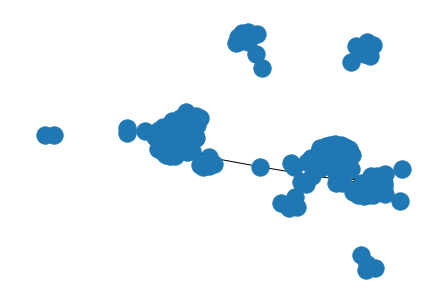

In [29]:
red_artistas= nx.Graph()
enlaces = []
for i in cuadrivectores_artistas_argentinos:
    enlaces.append(i[0:2])
print(enlaces)
red_artistas.add_edges_from(enlaces)
nx.draw(red_artistas)
nx.write_gexf(red_artistas, "artistas_argentinos_ari.gexf")


In [ ]:
#guardo
import pickle

# save graph object to file
pickle.dump(red_artistas, open('artistas_argentinos_ari', 'wb'))

Importo la red

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) # Montamos nuestra unidad de Google Drive

Mounted at /content/drive


In [ ]:
filename = '/content/drive/My Drive/Redes Complejas/TP Final/Archivos/red_rosalia_hasta_64.npz'
npzfile = np.load(filename)